In [1]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93
Receiving objects: 100% (96/96), 33.99 MiB | 28.12 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [5]:
%cd EEL6812_DeepFool_Project

/content/EEL6812_DeepFool_Project


In [6]:
import numpy as np
import json
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms

In [7]:
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

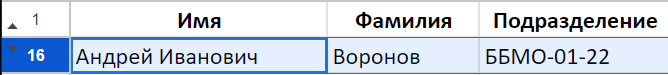

Для rand_seed = порядковый номер студента в таблице (16-1 за шапку таблицы = 15)

In [8]:
rand_seed = 15

In [9]:
# для numpy
np.random.seed(rand_seed)
# для torch
torch.manual_seed(rand_seed)

Среда выполнения сменяна на T4 GPU.

In [10]:
#Загрузка датасета MNIST
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(mean=0.0, std=1.0 / mnist_std),
    transforms.Normalize(mean=-mnist_mean, std=1.0)
])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

100%|██████████| 9912422/9912422 [00:00<00:00, 135064570.79it/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23677813.49it/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37421224.79it/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7372495.65it/s]


Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



In [11]:
# Загрузка датасета CIFAR-10
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(size=cifar_dim, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

cifar_tf_inv = transforms.Compose([ transforms.Normalize( mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)), transforms.Normalize( mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:05<00:00, 31565384.98it/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


In [12]:
# настройка и загрузка DataLoader
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
# Загрузка и оценка стойкости модели LeNet к FGSM и DeepFool атакам
fgsm_eps = 0.6

model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=torch.device('cpu')))

evaluate_attack('mnist_lenet_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max,
fgsm_eps, is_fgsm=True)

print('')

deep_args = [64, 10, 0.02, 100]

evaluate_attack('mnist_lenet_deepfool.csv', 'results', device, model,
mnist_loader_test, mnist_min, mnist_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us

DeepFool Test Error : 98.74%
DeepFool Robustness : 9.64e-02
DeepFool Time (All Images) : 193.32 s
DeepFool Time (Per Image) : 19.33 ms


In [14]:
# загрузка и оценка стойкости модели FC к FGSM и DeepFool атакам
fgsm_eps = 0.2

model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', map_location=device))

evaluate_attack('mnist_fc_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)

print('')

deep_args = [64, 10, 0.02, 100]

evaluate_attack('mnist_fc_deepfool.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms
